### Imports and cluster environment

In [4]:
import time
import pandas as pd
import sim
from sim.model import SeqFeatures, WildcatSimulation, tree_summary
from sim import sum_stats as ss
import tskit
import allel
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import elfi
import scipy.stats


### The simulator

In [5]:
def run_sim(length, recombination_rate, mutation_rate, pop_size_domestic_1, pop_size_wild_1,
            pop_size_captive, mig_rate_captive, mig_length_wild, mig_rate_wild,
            captive_time, pop_size_domestic_2, pop_size_wild_2, div_time, mig_rate_post_split,
            mig_length_post_split, bottleneck_time_wild, bottleneck_strength_wild,
            bottleneck_time_domestic, bottleneck_strength_domestic, random_seed, random_state):
    # TODO: add documentation
    ## NOTE RANDOM SEED SEEDS THE SIMULATION< RANDOM_STATE PROVIDES np.random.RandomState to elfi
    print(pop_size_domestic_1)
    # Constant sequence features
    seq_features = SeqFeatures(length, recombination_rate, mutation_rate)
    sim = WildcatSimulation(seq_features=seq_features, random_seed=random_seed)
    
    # run slim
    slim_param_dict = {
        "pop_size_domestic_1": pop_size_domestic_1,
        "pop_size_wild_1": pop_size_wild_1,
        "pop_size_captive": pop_size_captive,
        "mig_rate_captive": mig_rate_captive,
        "mig_length_wild": mig_length_wild,
        "mig_rate_wild": mig_rate_wild,
        "captive_time": captive_time
    }
    
    command = sim.slim_command(slim_param_dict)
    decap_trees = sim.run_slim(command)
    
    # run msprime
    recapitate_parameters = {
        'pop_size_domestic_2': pop_size_domestic_2,
        'pop_size_wild_2': pop_size_wild_2,
        'bottleneck_time_wild': bottleneck_time_wild,
        'bottleneck_strength_wild': bottleneck_strength_wild,
        'bottleneck_time_domestic': bottleneck_time_domestic,
        'bottleneck_strength_domestic': bottleneck_strength_domestic,
        'mig_rate_post_split': mig_rate_post_split,
        'mig_length_post_split': mig_length_post_split,
        'div_time': div_time,
    }
    
    demographic_events = sim.demographic_model(**recapitate_parameters)
    tree_seq = sim.recapitate(decap_trees, demographic_events)

    # Take samples to match number of samples to the WGS data
    samples = sim.sample_nodes(tree_seq, [5, 30, 10])  
    tree_seq = tree_seq.simplify(samples=np.concatenate(samples))
    return tree_seq

### Create pseudo-observed data

In [6]:
y_obs = sim.model.run_sim_vec(length=int(5e6),
            recombination_rate=1.8e-8,
            mutation_rate=6e-8,
            pop_size_domestic_1=np.array([50]),
            pop_size_wild_1=[50],
            pop_size_captive=[50],
            captive_time=[20],
            mig_rate_captive=[0.01],
            mig_length_wild=[20],
            mig_rate_wild=[0.01],
            pop_size_domestic_2=[200],
            pop_size_wild_2=[200],
            div_time=[30000],
            mig_rate_post_split=[0.1],
            mig_length_post_split=[5000],
            bottleneck_time_wild=[3000],
            bottleneck_strength_wild=[10000],
            bottleneck_time_domestic=[3000],
            bottleneck_strength_domestic=[10000],
            random_state=np.random.RandomState(3),
            batch_size=1,
            )

### Set up prior and constants

In [7]:
length = elfi.Constant(int(5e6))
recombination_rate = elfi.Constant(1.8e-8)
mutation_rate = elfi.Constant(6e-8)
pop_size_domestic_1 = elfi.Prior(scipy.stats.uniform, 100, 10000-100)  # scipy.stats.uniform(100, 15000),
pop_size_wild_1 = elfi.Prior(scipy.stats.lognorm, 0.4, 0, np.exp(8))  # scipy.stats.lognorm(0.4, scale=np.exp(8.5)),
pop_size_captive = elfi.Prior(scipy.stats.lognorm, 0.3, 0, np.exp(4.5))
mig_rate_captive = elfi.Prior(scipy.stats.beta, 1.2, 40)
captive_time = elfi.Prior(scipy.stats.lognorm, 0.7, 0, np.exp(3))
mig_length_wild = elfi.Prior(scipy.stats.lognorm, 0.7, 0, np.exp(3))
mig_rate_wild = elfi.Prior(scipy.stats.beta(2, 50))              
pop_size_domestic_2 = elfi.Prior(scipy.stats.uniform, 1000, 20000-1000)  # scipy.stats.uniform(1000, 25000),
pop_size_wild_2 = elfi.Prior(scipy.stats.lognorm, 0.2, 0, np.exp(8.8))  # scipy.stats.lognorm(0.2, scale=np.exp(9.2)),
bottleneck_strength_domestic = elfi.Prior(scipy.stats.uniform, 0, 40000-0)
bottleneck_time_domestic = elfi.Prior(scipy.stats.norm, 3500, 600)
bottleneck_strength_wild = elfi.Prior(scipy.stats.uniform, 0, 40000-0)
bottleneck_time_wild = elfi.Prior(scipy.stats.norm, 3500, 600)
mig_length_post_split = elfi.Prior(scipy.stats.uniform, 0, 10000-0)
mig_rate_post_split = elfi.Prior(scipy.stats.truncnorm, 0, 1, 0, 0.1)
div_time = elfi.Prior(scipy.stats.norm, 40000, 5000)

### Initiate simulator node

In [8]:
Y = elfi.Simulator(sim.model.run_sim_vec,
                   length, recombination_rate, mutation_rate, pop_size_domestic_1, pop_size_wild_1,
                   pop_size_captive, mig_rate_captive, mig_length_wild, mig_rate_wild,
                   captive_time, pop_size_domestic_2, pop_size_wild_2, div_time, mig_rate_post_split,
                   mig_length_post_split, bottleneck_time_wild, bottleneck_strength_wild,
                   bottleneck_time_domestic, bottleneck_strength_domestic, name="simulator", observed=y_obs)

### Set up summary functions

In [9]:
summaries = elfi.Summary(sim.sum_stats.collected_summaries, Y)

In [10]:
d = elfi.Distance('euclidean', summaries, name="Euclidean distance")

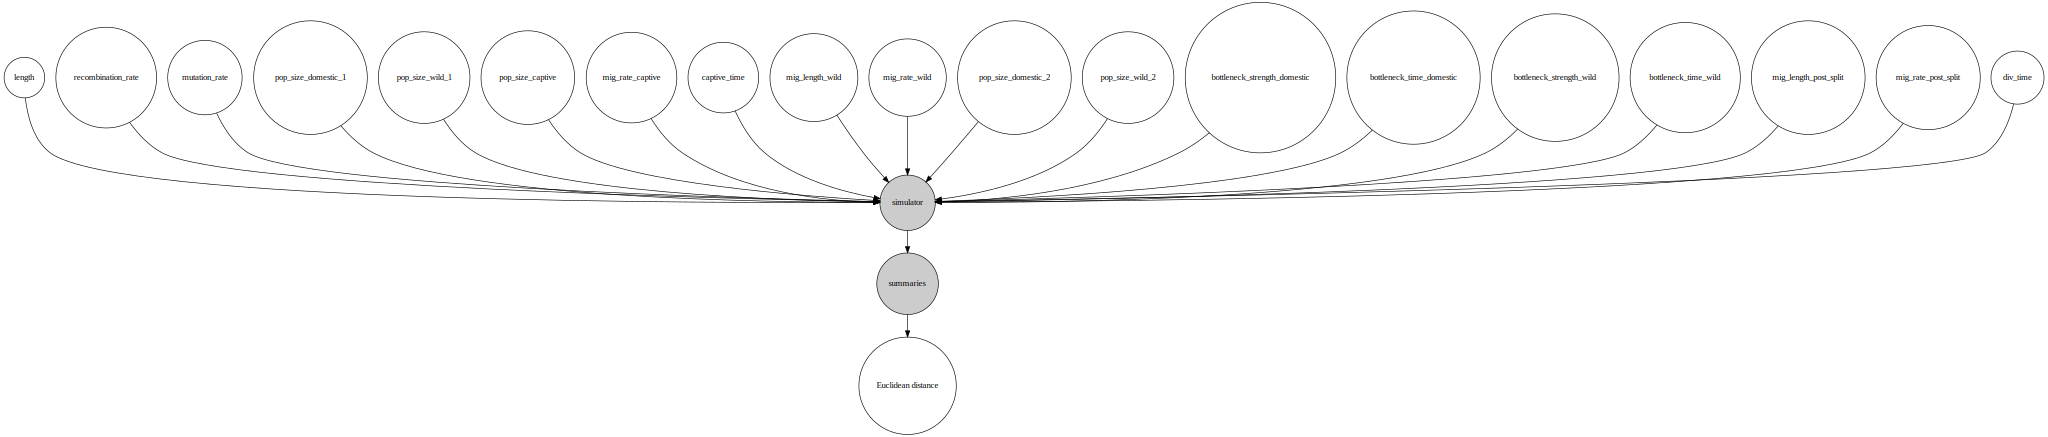

In [11]:
elfi.draw(Y, )

In [12]:
%%time
rej = elfi.Rejection(d, batch_size=1, seed=1)

Wall time: 1.99 ms


In [13]:
%%time
rej.sample(1, n_sim=2)

AttributeError: In executing node '_summaries_observed': 'function' object has no attribute 'count_alleles'.